In [3]:
%%capture
!pip install opacus

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import opacus

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [6]:
class ClassifierNN(nn.Module):
    def __init__(self):
        super(ClassifierNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        
        self.second_part = nn.Sequential(
            Flatten(),
            nn.Linear(588, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        f = self.first_part(x)
        return self.second_part(f)

In [7]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=32)

In [13]:
model = ClassifierNN().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
criterion = nn.NLLLoss()

# =============================================================

privacy_engine = opacus.PrivacyEngine()

model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.1,
    max_grad_norm=1.0,
)

# =============================================================

/opt/conda/lib/python3.8/site-packages/opacus/privacy_engine.py:114: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [14]:
model.train()

for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 250 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    scheduler.step()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Train Epoch: 0 [0/60000 (0%)]	Loss: -0.099507
Train Epoch: 0 [8000/60000 (13%)]	Loss: -0.101143
Train Epoch: 0 [16000/60000 (27%)]	Loss: -0.103378
Train Epoch: 0 [24000/60000 (40%)]	Loss: -0.239390
Train Epoch: 0 [32000/60000 (53%)]	Loss: -0.630644
Train Epoch: 0 [40000/60000 (67%)]	Loss: -0.780077
Train Epoch: 0 [48000/60000 (80%)]	Loss: -0.875858
Train Epoch: 0 [56000/60000 (93%)]	Loss: -0.877134
Train Epoch: 1 [0/60000 (0%)]	Loss: -0.794183
Train Epoch: 1 [8000/60000 (13%)]	Loss: -0.761450
Train Epoch: 1 [16000/60000 (27%)]	Loss: -0.784436
Train Epoch: 1 [24000/60000 (40%)]	Loss: -0.915579
Train Epoch: 1 [32000/60000 (53%)]	Loss: -0.792508
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.872879
Train Epoch: 1 [48000/60000 (80%)]	Loss: -0.889894
Train Epoch: 1 [56000/60000 (93%)]	Loss: -0.900707
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.855919
Train Epoch: 2 [8000/60000 (13%)]	Loss: -0.766910
Train Epoch: 2 [16000/60000 (27%)]	Loss: -0.801918
Train Epoch: 2 [24000/60000 (40%)]	Loss: -0.89816

----

In [15]:
class AttackerNN(nn.Module):
    def __init__(self):
        super(AttackerNN, self).__init__()
        self.layers = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=12, out_channels=12, kernel_size=3, stride=2, padding=0),
                            nn.LeakyReLU(),
                            nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=2),
                            nn.LeakyReLU(),
                            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=4, stride=1, padding=1),
                            nn.LeakyReLU(),
                         )
        
    def forward(self, x):
        return self.layers(x)

In [16]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=16)

In [17]:
attacker_model = AttackerNN().cuda()
optimiser = optim.Adam(attacker_model.parameters(), lr=1e-3)

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.cuda(), target.cuda()

        optimiser.zero_grad()

        target_outputs = model.first_part(data)

        attack_outputs = attacker_model(target_outputs)

        loss = ((data - attack_outputs)**2).mean()

        loss.backward()
        optimiser.step()

    print('Attacker train epoch: {},\tLoss: {:.6f}'.format(epoch, loss.item()))

Attacker train epoch: 0	Loss: 0.235761
Attacker train epoch: 1	Loss: 0.215822
Attacker train epoch: 2	Loss: 0.168351
Attacker train epoch: 3	Loss: 0.102939
Attacker train epoch: 4	Loss: 0.090248
Attacker train epoch: 5	Loss: 0.084825
Attacker train epoch: 6	Loss: 0.080976
Attacker train epoch: 7	Loss: 0.078298
Attacker train epoch: 8	Loss: 0.075998
Attacker train epoch: 9	Loss: 0.072636


---

tensor(3)


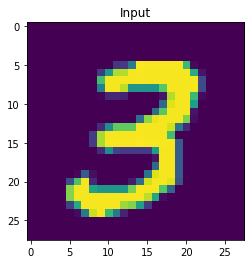

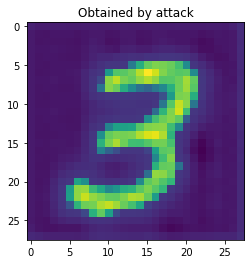

In [18]:
INDEX=7

for data, _ in train_loader:
    data = data.cuda()

    print(_[INDEX])
    
    target_outputs = model.first_part(data)
    attack_outputs = attacker_model(target_outputs)

    im_input = data[INDEX].detach().cpu().numpy()[0]
    im_attack = attack_outputs[INDEX].view(28,28).detach().cpu().numpy()
    
    plt.imshow(im_input)
    plt.title('Input')
    plt.show()
    
    plt.imshow(im_attack)
    plt.title('Obtained by attack')
    plt.show()
    
    break